In [ ]:
# All In One

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 1682 images belonging to 8 classes.
Found 862 images belonging to 8 classes.
Found 10 images belonging to 1 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 128)       73856   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


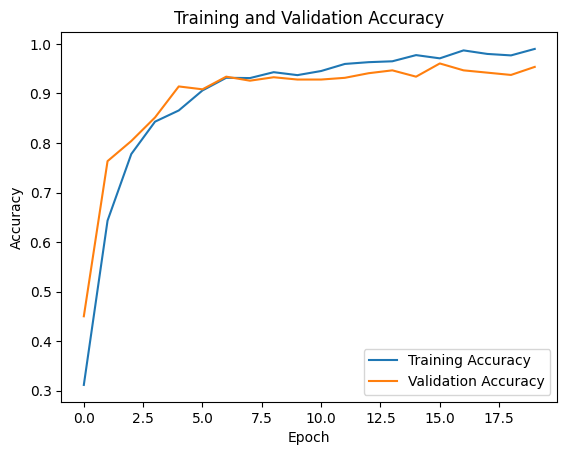

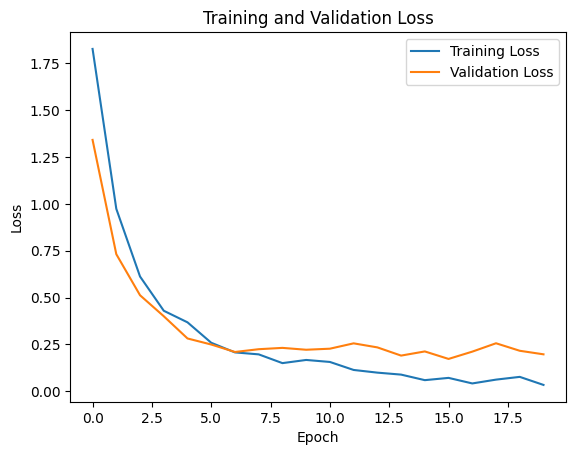

<Figure size 2500x2500 with 0 Axes>

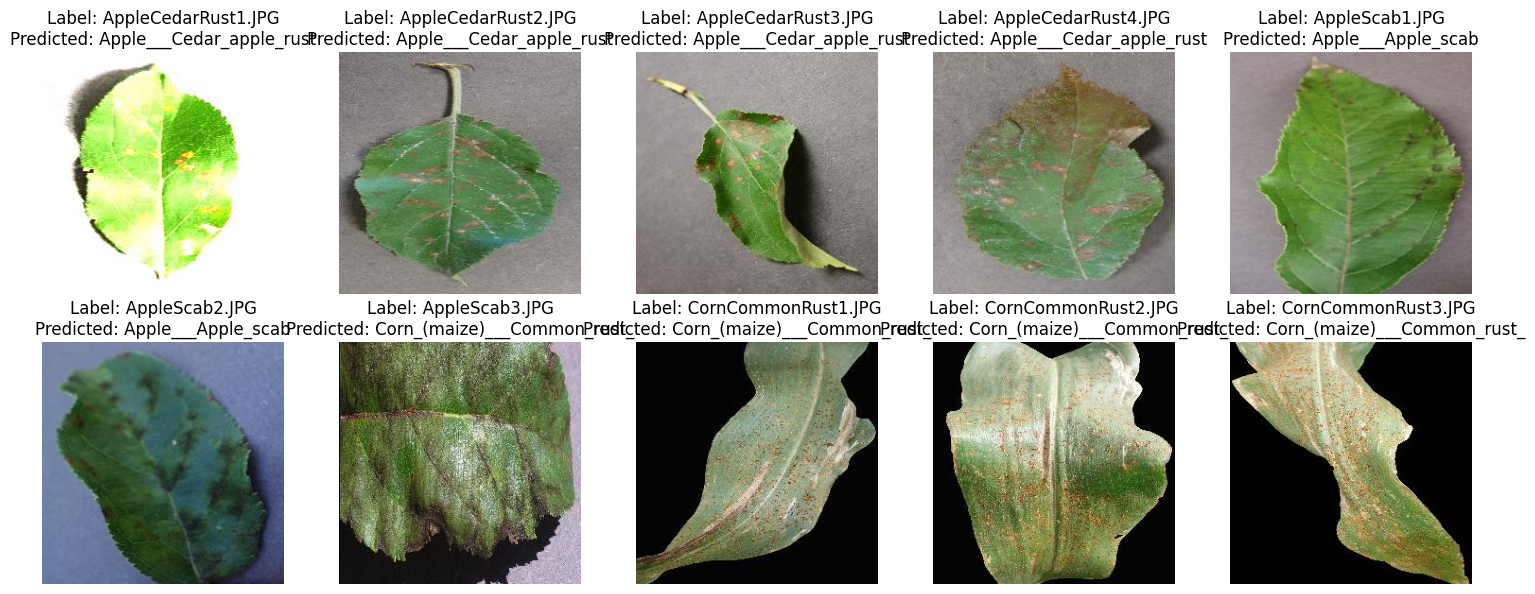

Classification Report for Test Dataset:
                                          precision    recall  f1-score   support

                      Apple___Apple_scab       0.00      0.00      0.00         2
                Apple___Cedar_apple_rust       1.00      0.25      0.40         4
                         Apple___healthy       0.00      0.00      0.00         0
Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00         0
       Cherry_(including_sour)___healthy       0.00      0.00      0.00         0
             Corn_(maize)___Common_rust_       0.00      0.00      0.00         4
     Corn_(maize)___Northern_Leaf_Blight       0.00      0.00      0.00         0
                  Corn_(maize)___healthy       0.00      0.00      0.00         0

                               micro avg       0.12      0.10      0.11        10
                               macro avg       0.12      0.03      0.05        10
                            weighted avg       0.40     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


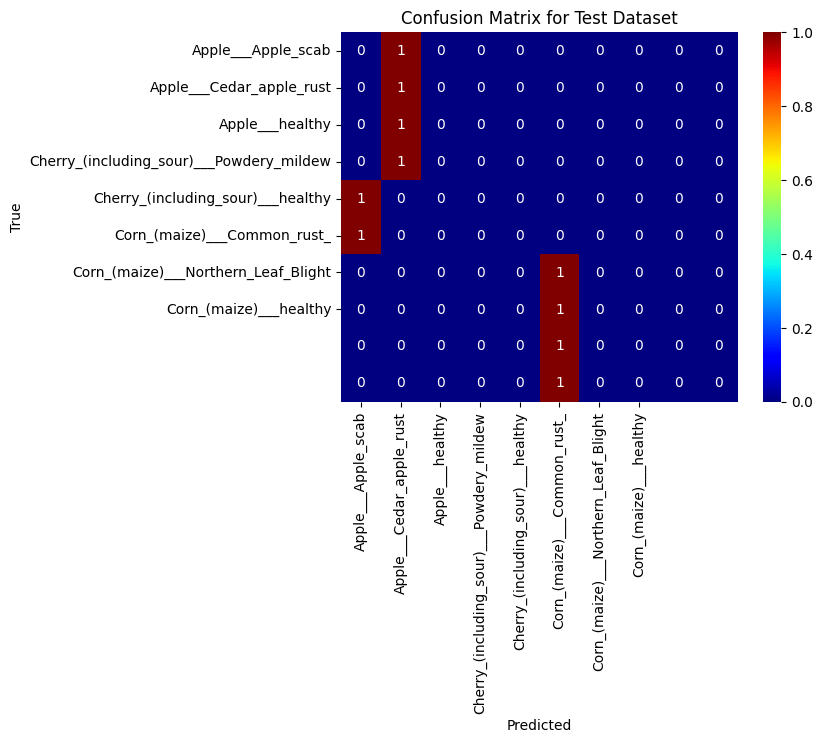

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

class PlantDiseaseClassifier:
    def __init__(self, train_path, valid_path, test_path, img_width=256, img_height=256, batch_size=32):
        self.train_path = train_path
        self.valid_path = valid_path
        self.test_path = test_path
        self.img_width = img_width
        self.img_height = img_height
        self.batch_size = batch_size
        self.labels = None
        self.train_generator = None
        self.validation_generator = None
        self.test_generator = None
        self.model = None

    def load_data(self):
        train_datagen = ImageDataGenerator(rescale=1./255)
        self.train_generator = train_datagen.flow_from_directory(
            self.train_path,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=True
        )

        validation_datagen = ImageDataGenerator(rescale=1./255)
        self.validation_generator = validation_datagen.flow_from_directory(
            self.valid_path,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False
        )

        test_datagen = ImageDataGenerator(rescale=1./255)
        self.test_generator = test_datagen.flow_from_directory(
            self.test_path,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode=None,
            shuffle=False
        )

        self.labels = self.train_generator.class_indices

    def create_model(self):
        model = keras.Sequential([
            keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(self.img_width, self.img_height, 3)),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(64, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(128, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(256, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(512, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(1568, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(len(self.labels), activation='softmax')
        ])

        opt = keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.summary()
        self.model = model

    def train_model(self, epochs=5):
        history = self.model.fit(self.train_generator, validation_data=self.validation_generator, epochs=epochs)
        return history

    def evaluate_model(self):
        test_loss, test_accuracy = self.model.evaluate(self.validation_generator, steps=len(self.validation_generator))
        print(f"Test Loss:     {test_loss}")
        print(f"Test Accuracy: {test_accuracy}")

    def predict(self):
        predictions = self.model.predict(self.test_generator)
        y_pred = np.argmax(predictions, axis=1)
        return y_pred

    def plot_confusion_matrix(self, y_true, y_pred):
        confusion = confusion_matrix(y_true, y_pred)
        sns.heatmap(confusion, annot=True, fmt='d', cmap='jet', xticklabels=self.labels.keys(), yticklabels=self.labels.keys())
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def print_classification_report(self, y_true, y_pred):
        print(classification_report(y_true, y_pred, target_names=self.labels.keys()))

    def save_model(self, model_path, labels_path):
        self.model.save(model_path)
        with open(labels_path, 'wb') as f:
            pickle.dump(self.labels, f)

# Define paths to your dataset directories
train_path = '/content/drive/MyDrive/train1'
valid_path = '/content/drive/MyDrive/valid'
test_path = '/content/drive/MyDrive/test1'

classifier = PlantDiseaseClassifier(train_path=train_path, valid_path=valid_path, test_path=test_path)
classifier.load_data()
classifier.create_model()
history = classifier.train_model(epochs=20)
classifier.evaluate_model()
y_pred = classifier.predict()

# Save the model and labels
model_path = 'plant_disease_model.h5'
labels_path = 'class_indices.pkl'
classifier.save_model(model_path, labels_path)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot predictions
plt.figure(figsize=(25,25))
test_filenames = classifier.test_generator.filenames
num_images = len(test_filenames)
num_rows = int(np.ceil(num_images / 5))
num_cols = min(num_images, 5)
plt.figure(figsize=(15, 3 * num_rows))
for i in range(num_images):
    img_path = os.path.join(classifier.test_path, test_filenames[i])
    img = plt.imread(img_path)
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    pred_label_idx = y_pred[i]
    predicted_label = list(classifier.labels.keys())[pred_label_idx]
    plt.title(f'Label: {os.path.basename(test_filenames[i])}\nPredicted: {predicted_label}')
plt.tight_layout()
plt.show()

print("Classification Report for Test Dataset:")
print(classification_report(y_pred, range(len(y_pred)), labels=range(len(classifier.labels.keys())), target_names=classifier.labels.keys()))
sns.heatmap(confusion_matrix(range(len(y_pred)), y_pred), annot=True, fmt='d', cmap='jet', xticklabels=classifier.labels.keys(), yticklabels=classifier.labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Dataset')
plt.show()
